# Project: Predicting the Presence of Heart Disease

### Introduction
   
Heart disease refers to the buildup of plaque in the heart's arteries that can ultimately lead to a heart attack, heart failure, or death.  [The Government of Canada website](https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html) identifies heart disease as the 2nd leading cause of death in Canada.  According to 2017–2018 data from the Canadian Chronic Disease Surveillance System (CCDSS):  
* about 1 in 12 (or 2.6 million) Canadian adults age 20 and over live with diagnosed heart disease
* every hour, about 14 Canadian adults age 20 and over with diagnosed heart disease die

Heart disease impacts a significant portion of the population and prevention of heart disease is clearly important so that more people can live longer, healthier lives.  The development of data-driven methods for predicting heart disease can be used to improve prevention processes by advancing our understanding of the associated risk factors and identifying disease at early onset to allow for rapid intervention.

The Cleveland Heart Disease database ([cleve.mod](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod)), available from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease), contains 14 variables related to heart disease diagnosis in 303 anonymous patients.  The variable information is as follows:    

* Age (years) 
* Sex (male or female)
* Chest pain type (typical angina, atypical angina, non-anginal pain, asymptomatic)
* Resting blood pressure (mm Hg)
* Cholesterol (mg/dl)
* Fasting blood sugar < 120 mg/dl (true or false)
* Resting electrocardiographic results (normal, abnormal, hypertrophy)
* Max. heart rate (BPM)
* Exercise induced angina (true or false)
* Oldpeak - ST depression induced by exercise relative to rest (mm)
* Slope - the slope of the peak exercise ST segment (upsloping, flat, down sloping)
* Number of major vessels colored by fluoroscopy (0 to 3)  
* Thalassemia blood disorder (normal, fixed defect, reversible defect)
* Presence of heart disease (yes or no)

This project aims to answer the question: can we use the Cleveland Heart Disease data set to develop a classification model to predict the presence of heart disease in a patient, and if so, what is the accuracy of the classification model?

<img src="https://www.heart.org/-/media/Images/News/2019/July-2019/0725LifeExpectancy_SC.jpg?h=600&w=800&hash=77AD97769808EC7B6D24843976A7CE99" alt="Life Expectancy" height="400" width="400" />

### Exploratory Analysis
In the exploratory analysis, we read the Cleveland Heart Disease data set from the web into R 
and clean and wrangle the data into a tidy format.  From the initial set of 13 possible predictor variables we can eliminate those that do not contain numerical data, reducing the number of possible predictor variables to 6 (i.e., age, resting blood pressure, cholesterol, max. heart rate, oldpeak, and number of major vessels colored). We split the data into a training and testing sets assuming a 75/25 split and then generate summary tables and visualizations (box plots and bar charts) from the testing set to determine which numerical variables to use to predict the categorical class variable (presence of heart disease).



Source of data set: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod

In [14]:
# load libraries and set seed value
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

In [21]:
# read data set from web
data <- read_table("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod", skip = 19, col_names=FALSE) 

# assign column names
colnames(data) <- c("age", 
                    "sex", 
                    "chest_pain_type", 
                    "resting_blood_pres", 
                    "cholesterol", 
                    "fasting_blood_sugar", 
                    "resting_ecg", 
                    "max_heart_rate", 
                    "exercise_induced_angina", 
                    "oldpeak", 
                    "slope", 
                    "number_of_vessels_colored", 
                    "thal", 
                    "presence_of_heart_disease", 
                    "sickness_classifier")

# select numerical variables and class variable to predict, mutate required variables to numeric / factor and replace cells to improve readability
data_selected <- data |>
    select("age", "sex", "resting_blood_pres", "cholesterol", "fasting_blood_sugar", "resting_ecg", "max_heart_rate", "exercise_induced_angina",
     "oldpeak", "number_of_vessels_colored", "presence_of_heart_disease")

# change boolean(true/false) and categorical values into numerical values in order yo visualize the affect
data_mutated <- data_selected |>
    mutate(sex = replace(sex, sex == "male", 0)) |>
    mutate(sex = replace(sex, sex == "fem", 1)) |>
    mutate(sex = as.numeric(sex)) |>

    mutate(fasting_blood_sugar = replace(fasting_blood_sugar, fasting_blood_sugar == "true", 1)) |>
    mutate(fasting_blood_sugar = replace(fasting_blood_sugar, fasting_blood_sugar == "fal", 0)) |>
    mutate(fasting_blood_sugar = as.numeric(fasting_blood_sugar)) |>

    mutate(fasting_blood_sugar = replace(fasting_blood_sugar, fasting_blood_sugar == "true", 1)) |>
    mutate(fasting_blood_sugar = replace(fasting_blood_sugar, fasting_blood_sugar == "fal", 0)) |>
    mutate(fasting_blood_sugar = as.numeric(fasting_blood_sugar)) |>

    mutate(resting_ecg = replace(resting_ecg, resting_ecg == "norm", 0)) |>
    mutate(resting_ecg = replace(resting_ecg, resting_ecg == "abn", 1)) |>
    mutate(resting_ecg = replace(resting_ecg, resting_ecg == "hyp", 2)) |>
    mutate(resting_ecg = as.numeric(resting_ecg)) |>

    mutate(exercise_induced_angina = replace(exercise_induced_angina, exercise_induced_angina == "true", 1)) |>
    mutate(exercise_induced_angina = replace(exercise_induced_angina, exercise_induced_angina == "fal", 0)) |>
    mutate(exercise_induced_angina = as.numeric(exercise_induced_angina)) |>

    mutate(number_of_vessels_colored = as.numeric(number_of_vessels_colored)) |>

    mutate(presence_of_heart_disease = replace(presence_of_heart_disease, presence_of_heart_disease == "buff", "no")) |>
    mutate(presence_of_heart_disease = replace(presence_of_heart_disease, presence_of_heart_disease == "sick", "yes")) |>
    mutate(presence_of_heart_disease = as_factor(presence_of_heart_disease))

# re-order columns
data_ordered <- bind_cols(select(data_mutated, presence_of_heart_disease),select(data_mutated, -presence_of_heart_disease))

# summarize the number of missing data
summary_na_table <- data_ordered |> 
group_by(presence_of_heart_disease) |>
map_df(~sum(is.na(.)))

# remove rows with na data from data set (5 rows total)
data_prelim <- data_ordered |>
    filter(number_of_vessels_colored != "NA")


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  X2 = col_character(),
  X3 = col_character(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_double(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_character(),
  X15 = col_character()
)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [16]:
# print summary of the number of missing data
summary_na_table

presence_of_heart_disease,age,sex,resting_blood_pres,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,oldpeak,number_of_vessels_colored
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,5


##### Table 1: Summary of the number of missing data (i.e., NA values) for each variable in the heart disease data set 

In [17]:
# print final data set
data_prelim

presence_of_heart_disease,age,sex,resting_blood_pres,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,oldpeak,number_of_vessels_colored
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,63,0,145,233,1,2,150,0,2.3,0
yes,67,0,160,286,0,2,108,1,1.5,3
yes,67,0,120,229,0,2,129,1,2.6,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
yes,49,0,118,149,0,2,126,0,0.8,3
no,74,1,120,269,0,2,121,1,0.2,1
no,54,1,160,201,0,0,163,0,0.0,1


##### Table 2: Preliminary heart disease data set

In [18]:
set.seed(2000)

#split data into training and testing sets
data_split <- initial_split(data_prelim, prop = .75, strata = presence_of_heart_disease)
data_training <- training(data_split)
data_testing <- testing(data_split)


In [19]:
# print training data set
data_training

presence_of_heart_disease,age,sex,resting_blood_pres,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,oldpeak,number_of_vessels_colored
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,63,0,145,233,1,2,150,0,2.3,0
no,37,0,130,250,0,0,187,0,3.5,0
no,41,1,130,204,0,2,172,0,1.4,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
yes,42,0,136,315,0,0,125,1,1.8,0
yes,77,0,125,304,0,2,162,1,0.0,3
yes,49,0,118,149,0,2,126,0,0.8,3


##### Table 3: Heart disease training data set

In [20]:
# print testing data set
data_testing

presence_of_heart_disease,age,sex,resting_blood_pres,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,oldpeak,number_of_vessels_colored
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
yes,67,0,160,286,0,2,108,1,1.5,3
yes,53,0,140,203,1,2,155,1,3.1,0
yes,56,0,130,256,1,2,142,1,0.6,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
no,68,0,118,277,0,0,151,0,1,1
no,48,0,124,255,1,0,175,0,0,2
no,54,1,160,201,0,0,163,0,0,1


##### Table 4: Heart disease testing data set

In [21]:
# summarize the number of observations in each class in training set
summary_obs_table <- data_training |> 
group_by(presence_of_heart_disease) |>
summarize(count=n())
summary_obs_table

presence_of_heart_disease,count
<fct>,<int>
no,120
yes,102


##### Table 5: Summary of the number of observations for the classification variable (presence of heart disease) in the training data set
*From this 123 and 103 split, we can see that the data is evenly distributed and both sides can be trained properly.*

In [22]:
# summarize mean values for each potential predictor variable in training set
summary_mean_table <- data_training |> 
group_by(presence_of_heart_disease) |>
summarize(across(age:number_of_vessels_colored, mean)) 
summary_mean_table

presence_of_heart_disease,age,sex,resting_blood_pres,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,oldpeak,number_of_vessels_colored
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,52.67500,0.4666667,129.3250,247.3500,0.1416667,0.8583333,159.4500,0.1500000,0.6133333,0.2916667
yes,57.23529,0.1764706,133.5686,252.2843,0.1666667,1.2058824,139.0686,0.5098039,1.5382353,1.2058824


##### Table 6: Summary of mean values for each predictor variable in the training data set

In [39]:
# generate box-plot visualizations
options(repr.plot.width = 8, repr.plot.height = 8)

age_plot <- data_training |>
    ggplot(aes(y = age, x = presence_of_heart_disease)) + 
    geom_boxplot() + 
    ylab("Age (years)") +
    xlab("Heart Disease") +
    ggtitle("Fig.1: Age") +
    theme(text = element_text(size = 17))

rbp_plot <- data_training |>
    ggplot(aes(y = resting_blood_pres, x = presence_of_heart_disease)) + 
    geom_boxplot() + 
    ylab("Resting Blood Pressure (mm Hg)") +
    xlab("Heart Disease") +
    ggtitle("Fig. NA: Resting Blood Pressure") +
    theme(text = element_text(size = 17))

cholesterol_plot <- data_training |>
    ggplot(aes(y = cholesterol, x = presence_of_heart_disease)) + 
    geom_boxplot() +
    ylab("Cholesterol (mg/dl)") +
    xlab("Heart Disease") +
    ggtitle("Fig. NA: Cholesterol") +
    theme(text = element_text(size = 17))

oldpeak_plot <- data_training |>
    ggplot(aes(y = oldpeak, x = presence_of_heart_disease)) + 
    geom_boxplot() +
    ylab("Old Peak (mm)") +
    xlab("Heart Disease") +
    ggtitle("Fig. 2: Old Peak") +
    theme(text = element_text(size = 17))

mhr_plot <- data_training |>
    ggplot(aes(y = max_heart_rate, x = presence_of_heart_disease)) + 
    geom_boxplot() +
    ylab("Max. Heart Rate (BPM)") +
    xlab("Heart Disease") +
    ggtitle("Fig. 3: Max. Heart Rate") +
    theme(text = element_text(size = 17))

# generate bar graph visualizations

sex_plot <- data_training |>
    ggplot(aes(x = sex, fill = presence_of_heart_disease)) + 
    geom_bar(position = "fill") +
    labs(x = "Sex \n (0 = Male, 1 = Female)", y = "Frequency", fill = "Heart Disease") +
    scale_x_continuous(breaks=seq(0, 1)) +
    ggtitle("Fig. 4: Sex") +
    theme(text = element_text(size = 17))

fasting_blood_sugar_plot <- data_training |>
    ggplot(aes(x = fasting_blood_sugar, fill = presence_of_heart_disease)) + 
    geom_bar(position = "fill") +
    labs(x = "Fasting Blood Sugar < 120 mg/dl \n (0 = False, 1 = True)", y = "Frequency", fill = "Heart Disease") +
    scale_x_continuous(breaks=seq(0, 1)) +
    ggtitle("Fig. NA: Fasting Blood Sugar") +
    theme(text = element_text(size = 17))

resting_ecg_plot <- data_training |>
    ggplot(aes(x = resting_ecg, fill = presence_of_heart_disease)) + 
    geom_bar(position = "fill") +
    labs(x = "Resting ECG \n (0 = Normal, 1 = Abnormal, 3 = Hypertrophy)", y = "Frequency", fill = "Heart Disease") +
    scale_x_continuous(breaks=seq(0, 2, 1)) +
    ggtitle("Fig. 5: Resting ECG") +
    theme(text = element_text(size = 17))

exercise_induced_angina_plot <- data_training |>
    ggplot(aes(x = exercise_induced_angina, fill = presence_of_heart_disease)) + 
    geom_bar(position = "fill") +
    labs(x = "Exercise-Induced Angina \n (0 = False, 1 = True)", y = "Frequency", fill = "Heart Disease") +
    scale_x_continuous(breaks=seq(0, 1)) +
    ggtitle("Fig. 6: Exercise-Induced Angina") +   
    theme(text = element_text(size = 17))

data_vessels_plot <- data_training |>
    ggplot(aes(x = number_of_vessels_colored, fill = presence_of_heart_disease)) +
    geom_bar(position = "fill") +
    labs(x = "Number of Vessels Colored", y = "Frequency", fill = "Heart Disease", title = "Fig. 7: Vessels Colored") +
    scale_x_continuous(breaks=seq(0, 3, 1)) +
    theme(text = element_text(size = 17))

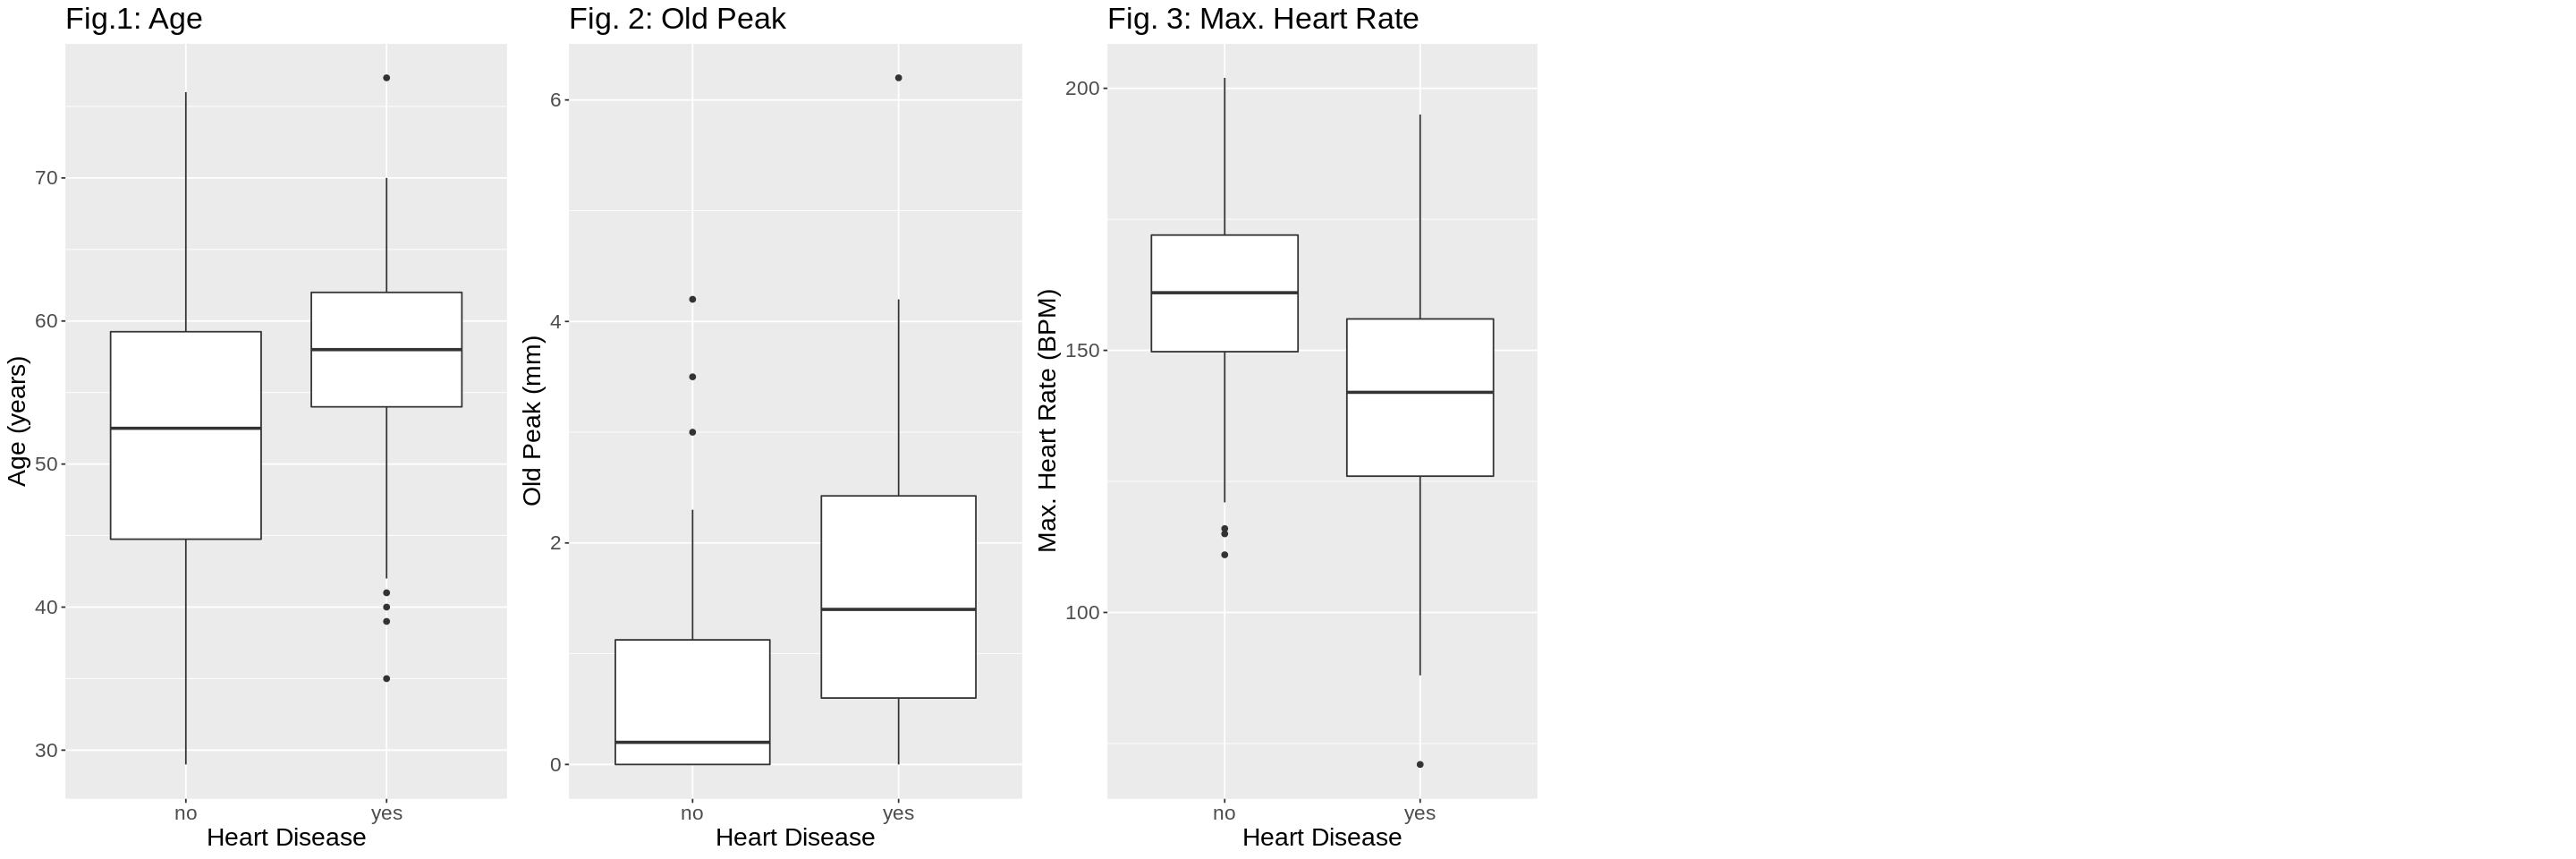

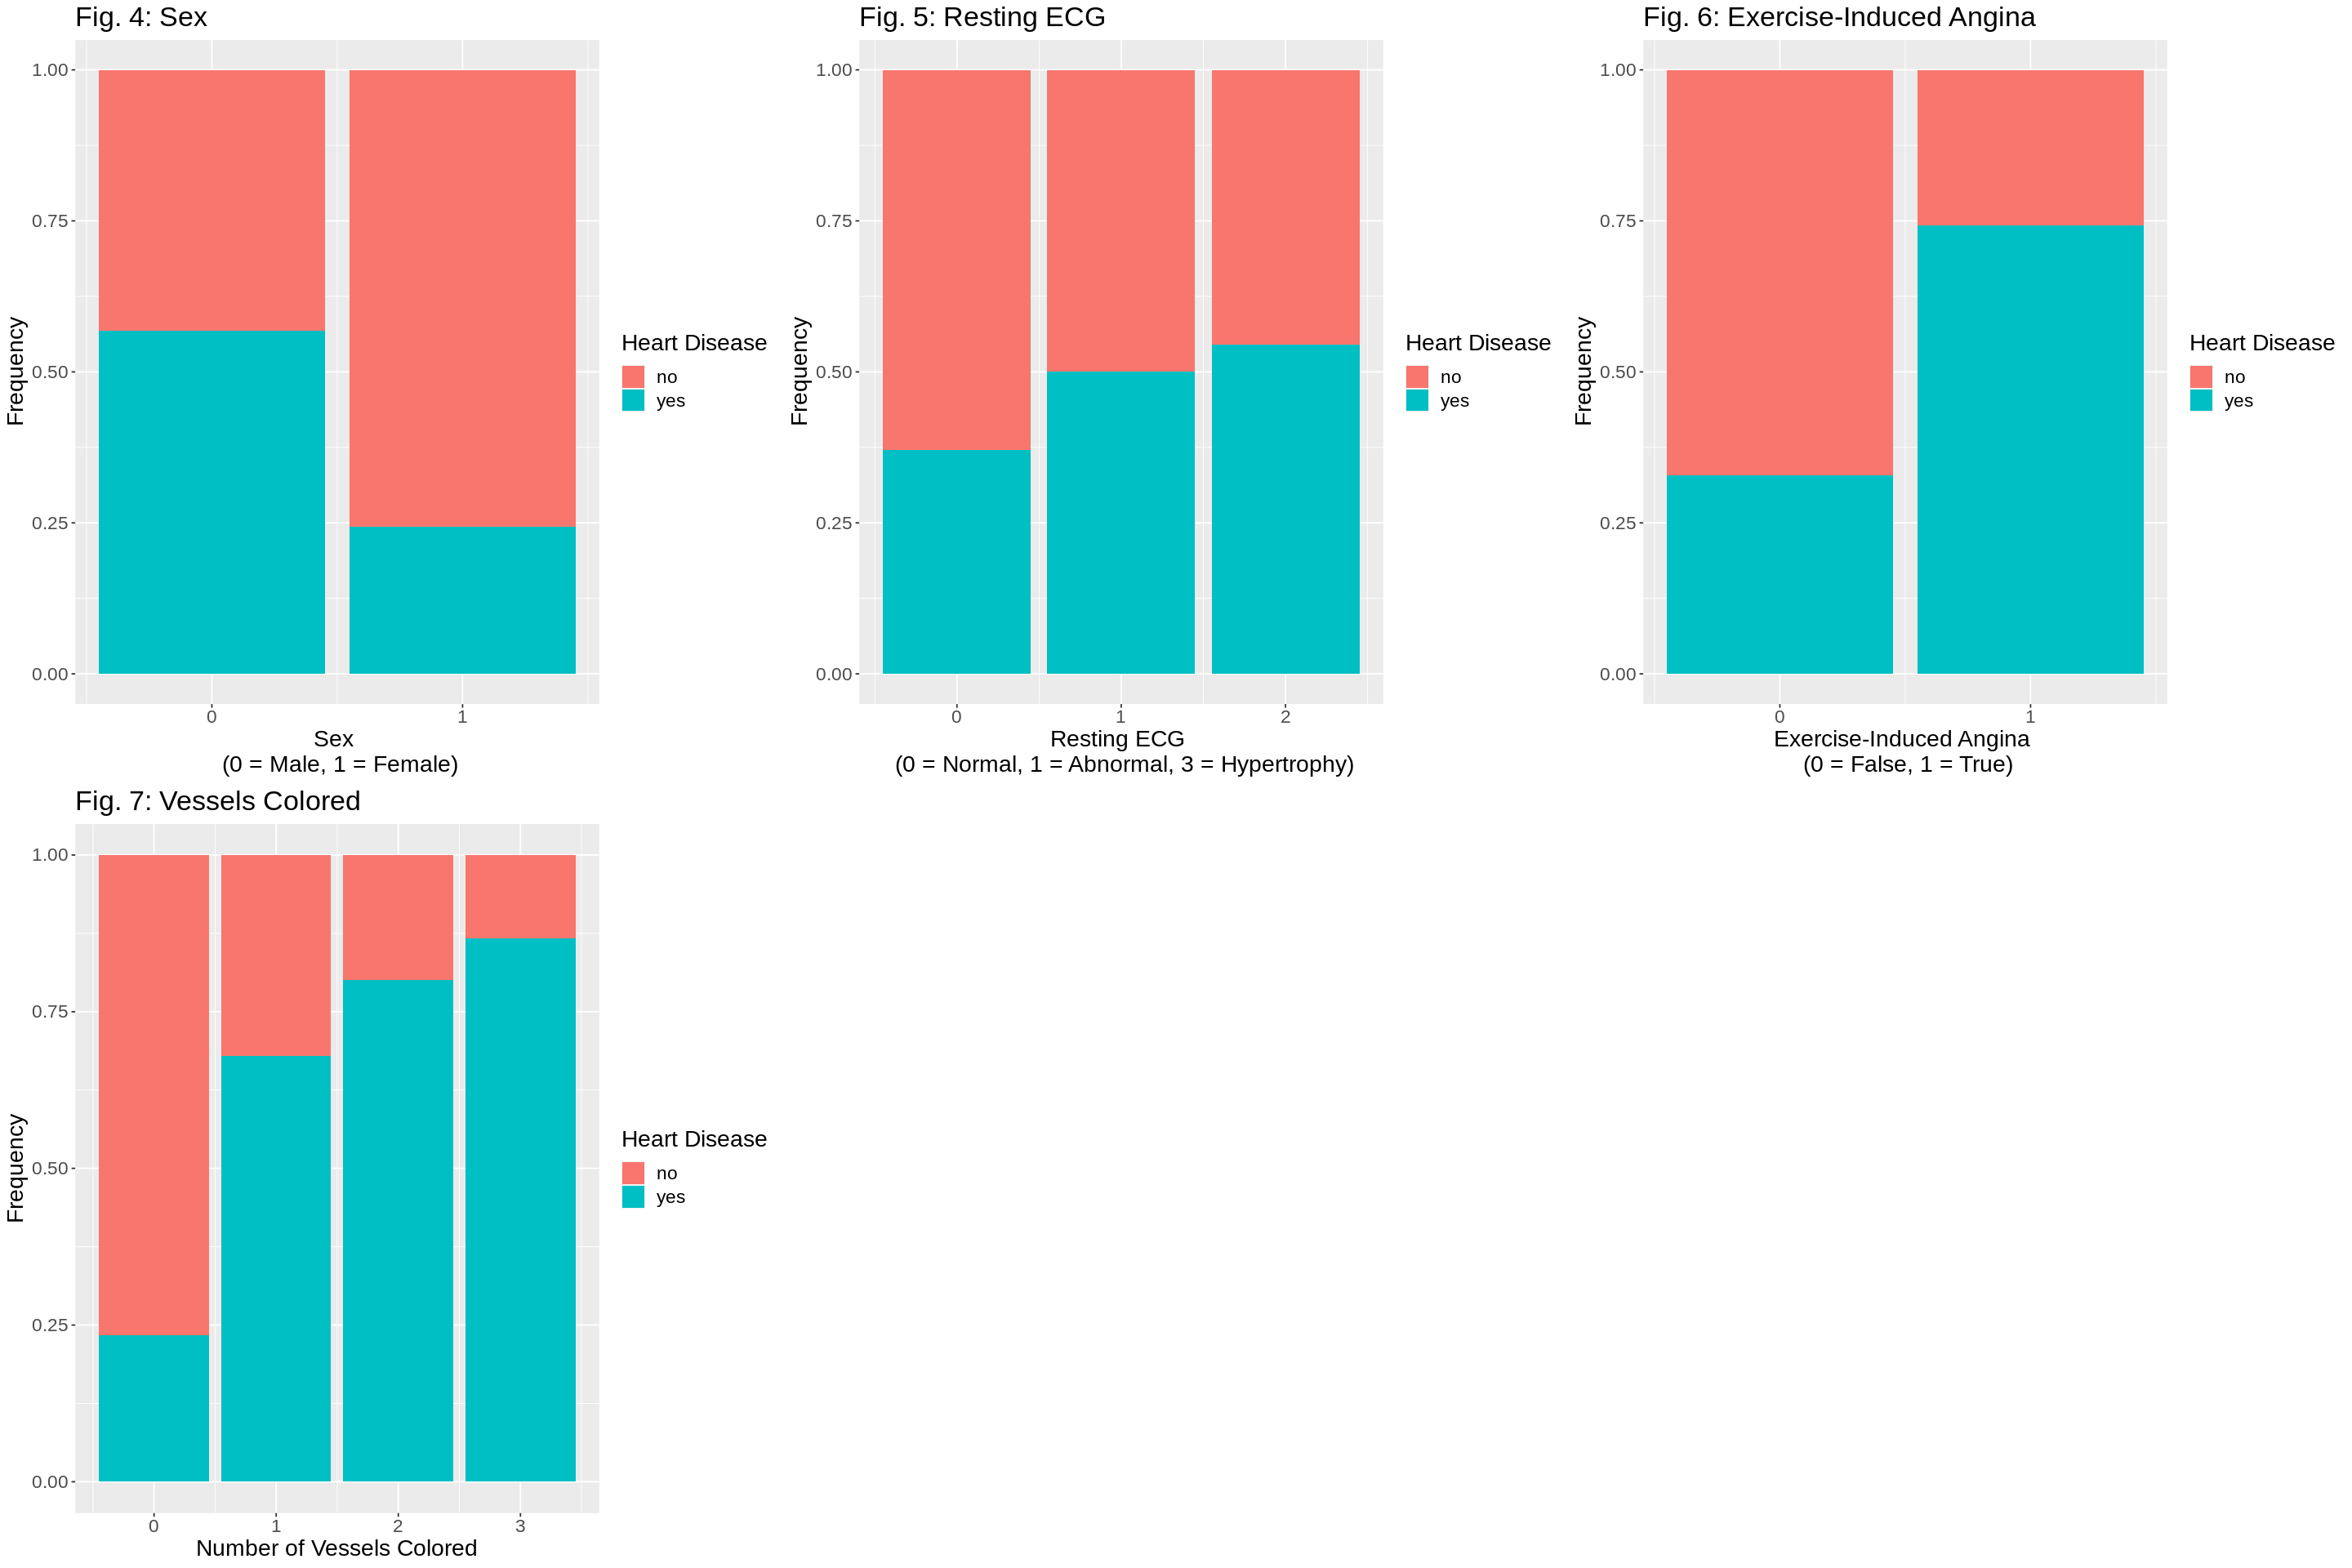

In [40]:
options(repr.plot.width = 24, repr.plot.height = 8)

plot_grid_1 <- plot_grid(age_plot, oldpeak_plot, mhr_plot, ncol = 5)
plot_grid_1

options(repr.plot.width = 24, repr.plot.height = 16)
plot_grid_2 <- plot_grid(sex_plot, resting_ecg_plot,
                         exercise_induced_angina_plot, data_vessels_plot, ncol = 3, nrow = 2)
plot_grid_2

Predictors to include (7 total): Age, Old Peak, Max. Heart Rate, Sex, Resting ECG, Exercise Induced-Angina, Vessels Colored

Based on the above graphs and tables, it can be concluded that age, old peak, maximum heart rate, and number of vessels colored, all show an association with the presence of heart disease and therefore are good candidates to include in our model for predicting heart disease. In contrast, resting blood pressure and cholesterol show little to no association with the presence of heart disease and therefore will not be included as predictors in the classification model.

In [41]:
set.seed(2000) 

hd_recipe <- recipe(presence_of_heart_disease ~ age + max_heart_rate + oldpeak + sex + 
                    resting_ecg + exercise_induced_angina + number_of_vessels_colored, 
                    data = data_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine ("kknn") |>
    set_mode ("classification")

hd_vfold <- vfold_cv(data_training, v = 10, strata = presence_of_heart_disease)
grid_vals <- tibble(neighbors = seq(1, 25))

hd_results <- workflow() |>
    add_recipe(hd_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = hd_vfold, grid = grid_vals) |>
    collect_metrics() |>
    filter (.metric == "accuracy") |>
    arrange(desc(mean))
hd_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.8114625,10,0.03376460,Preprocessor1_Model21
22,accuracy,binary,0.8114625,10,0.03376460,Preprocessor1_Model22
15,accuracy,binary,0.8071146,10,0.03702005,Preprocessor1_Model15
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6,accuracy,binary,0.7660079,10,0.03417468,Preprocessor1_Model06
3,accuracy,binary,0.7298419,10,0.03302893,Preprocessor1_Model03
4,accuracy,binary,0.7298419,10,0.03302893,Preprocessor1_Model04


In [ ]:
k_best <- hd_results |>
    arrange(desc(mean)) |>
    select(neighbors) |>
    slice(1) |>
    pull()

ky <- hd_results |>
    filter(neighbors == k_best) |>
    select(mean) |>
    pull()

cross_val_plot <- hd_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = k_best, colour = "red") +
    geom_point(aes(x = k_best, y = ky), size = 4, colour = "blue") +
    labs(x = "\nNeighbours",
         y = "Accuracy Estimate\n",
         title = "Fig. 11: Estimated Accuracies of k Neighbours") +
    scale_x_continuous(limits = c(1, 25),
                       breaks = seq(1, 25),
                       minor_breaks = seq(1, 25, 1)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))

cross_val_plot

In [18]:
set.seed(2000) 

knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_best) |>
    set_engine ("kknn") |>
    set_mode ("classification")

hd_fit <- workflow() |>
    add_recipe(hd_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = data_training) 

hd_predictions <- predict(hd_fit, data_testing) |>
    bind_cols(data_testing)

# compare the accuracy of predictions to the true values in the test set
hd_acc <- hd_predictions |> 
    metrics(truth = presence_of_heart_disease, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

# compare the predictions to the true values in a confusion matrix
hd_cm <- hd_predictions |> 
    conf_mat(truth = presence_of_heart_disease, estimate = .pred_class)


In [19]:
hd_acc

.metric,.estimate
<chr>,<dbl>
accuracy,0.7763158


In [20]:
hd_cm

          Truth
Prediction no yes
       no  36  12
       yes  5  23

### Methods & Results

Before we start building our k-nn classification model, we used visualizations (boxplots and bar graph) to see if there is an association between each predictor variable and the presence of heart disease   We concluded that age, sex, number of vessels colored, old peak, resting ECG, Exercise-Induced Angina and max heart rate are the best predictors to include in our model. 

##### Methods used:

1. Created a knn classification model using k = tune(), and a recipe that used the 4 parameters mentioned above as predictors on the training set and that scales and centers all the predictors.
2. Applied cross-validation on the training data to find the average accuracy from our training set’s prediction using vfold_cv() that folded the data 10 times. 
3. Generated a workflow using tune_grid to get control over range of the data in which we pick the k, and applied collect_metrics() for plotting.
4. Plotted K using both geom_point() and geom_line() with a vertial line going through the largest k computed using arrange(desc(mean)).
5. Rebuilt knn model with the k we found.
6. Passed the new model and recipe into a new workflow using the training set and call fit().
7. Predicted our classification result by passing the fitted training object and testing set into the predict() as arguments and bind cols. 
8. Analyzed accuracy using confusion matrices

##### Numerical Results produced:
* The accuracy of our model behaving on the testing data set is arround 78%
* The classifier misdiagonosed heart diseases under yes coloumn with an accuracy of 65% and under no column with an accuracy of 83% according to the confusion matrix
* Overall, the classifier has a 78% accuracy

### Discussion

We found that our model could relatively accurately predict the presence of heart disease given seven predictors: age, old peak, number of colored blood vessels, maximum heart rate, sex, resting ECG, and exercise-induced angina. The model was able to predict at a 77.6% accuracy, which is better than a randomly predicted model of 54% (one where no is predicted 100% of the time), and similar to the prediction from the American Journal of Cardiology which had an accuracy of around 77% (Detrano, Janosi, et al., 1989). This is what we expected to find in our initial projections. However, even though this prediction model shows relatively accurate results, it still needs to be more accurate to have actual medical applications in the real world. A 23% rate of incorrectly diagnosing somebody is far too large to use when the impacts could be fatal. However, these findings do lead to future questions regarding heart disease prediction. For example, if more predictors were available, would the accuracy increase? Does the accuracy of the prediction model change based on geographical location? Overall, while the current model is an accurate prediction for the given information, it is still not enough to apply it to the medical field unless further processes are done to increase accuracy.

### Citations

Detrano, R.(1990). "cleve.mod". Heart Disease Data Set, UCI machine learning repository. https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod

Detrano, R., Janosi, A., et al.(1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. American Journal of Cardiology, 64,304--310.

"Heart Disease in Canada".(2022). Government of Canada. https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html

"Here's How Many Years You Could Gain By Keeping Heart Disease At Bay".(2019). Heart.org. https://www.heart.org/-/media/Images/News/2019/July-2019/0725LifeExpectancy_SC.jpg?h=600&w=800&hash=77AD97769808EC7B6D24843976A7CE99